In [1]:
from mip import *
import datetime
import pandas as pd
import numpy as np
from EMS import *

In [2]:
PARAM = {}
# add length check with res & horizon
PARAM['Horizon'] = 4*24*60        # horizon to optimize (min)
PARAM['Resolution'] = 15    # sampling period(min)
PARAM['PV_capacity'] = 50   # (kw) PV sizing for this EMS
TOU = getBuySellrate(Resolution=PARAM['Resolution'],
                                    Horizon=PARAM['Horizon'],
                                    TOU_CHOICE='THcurrent',
                                    start_time=datetime.timedelta(minutes=60))
PARAM['Buy_rate'] = TOU['buy'].to_numpy()
PARAM['Sell_rate'] = TOU['sell'].to_numpy()

PARAM['battery'] = {}
PARAM['battery']['charge_effiency'] = [0.95,0.95];              #  bes charge eff
PARAM['battery']['discharge_effiency'] = [0.95*0.93,0.95*0.93]; #  bes discharge eff note inverter eff 0.93-0.96
PARAM['battery']['discharge_rate'] = [30,30]; # kW max discharge rate
PARAM['battery']['charge_rate'] = [30,30]; # kW max charge rate
PARAM['battery']['actual_capacity'] = [125,125]; # kWh soc_capacity 
PARAM['battery']['initial'] = [50,50]; # userdefined int 0-100 %
PARAM['battery']['min'] = [20,20]; #min soc userdefined int 0-100 %
PARAM['battery']['max'] = [80,80]; #max soc userdefined int 0-100 %
PARAM['battery']['num_batt'] = len(PARAM['battery']['actual_capacity'])

In [3]:
root_folder = 'historical/'
load_data = pd.read_csv(root_folder + 'load_data_15minresample_concat.csv',parse_dates=['datetime'])
pv_data = pd.read_csv(root_folder + 'pv_data_15minresample_concat.csv',parse_dates=['datetime'])
pv_scaling_factor = 50/8 # scale PV from 8 kW to 50 kW conversion factor conversion kW/(W/m^2)
# scale PV and PV >= 0
pv_data.iloc[:,1:] = pv_data.iloc[:,1:].clip(lower=0)*pv_scaling_factor

# load must >= 0
load_data.iloc[:,1:] = load_data.iloc[:,1:].clip(lower=0)


In [4]:
pv_data

,datetime,Ia (A),Ib (A),Ic (A),Pa (kW),Pb (kW),Pc (kW),Ptot (kW),VAa (kVA),VAb (kVA),VAc (kVA),VAtot (kVA)
0,2023-03-09 00:00:00,2.0000,1.9375,2.0000,0.257437,0.0,0.335500,0.172250,0.0,0.0,0.0,0.0
1,2023-03-09 00:15:00,2.0000,1.9375,2.0000,0.257437,0.0,0.335500,0.172250,0.0,0.0,0.0,0.0
2,2023-03-09 00:30:00,2.0000,1.9375,2.0000,0.257437,0.0,0.335500,0.172250,0.0,0.0,0.0,0.0
3,2023-03-09 00:45:00,2.0000,1.9375,2.0000,0.257437,0.0,0.335500,0.172250,0.0,0.0,0.0,0.0
4,2023-03-09 01:00:00,2.0000,1.9375,2.0000,0.257437,0.0,0.335500,0.172250,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33787,2024-02-29 22:45:00,2.5625,2.7500,2.6875,0.271187,0.0,0.721375,0.411563,0.0,0.0,0.0,0.0
33788,2024-02-29 23:00:00,2.5625,2.7500,2.6875,0.271187,0.0,0.721375,0.411563,0.0,0.0,0.0,0.0
33789,2024-02-29 23:15:00,2.5625,2.7500,2.6875,0.271187,0.0,0.721375,0.411563,0.0,0.0,0.0,0.0
33790,2024-02-29 23:30:00,2.5625,2.7500,2.6875,0.271187,0.0,0.721375,0.411563,0.0,0.0,0.0,0.0


In [5]:
PARAM['Start_date'] = pd.to_datetime('2023-04-16 00:00:00')

PARAM['PV'] = pv_data[ (pv_data['datetime'] >= PARAM['Start_date'])  & (pv_data['datetime'] < PARAM['Start_date'] + pd.Timedelta(minutes=PARAM['Horizon']))  ]['Ptot (kW)'].to_numpy().flatten()
PARAM['PL'] = load_data[ (load_data['datetime'] >= PARAM['Start_date'])  & (load_data['datetime'] < PARAM['Start_date'] + pd.Timedelta(minutes=PARAM['Horizon']))  ]['Ptot (kW)'].to_numpy().flatten()    

In [6]:
PARAM['PL'].shape,PARAM['PV'].shape

((384,), (384,))

In [7]:
sol = EMS_1_opt(PARAM,energycost=1,multibatt=1,chargebatt=1,smoothcharge=0.3)

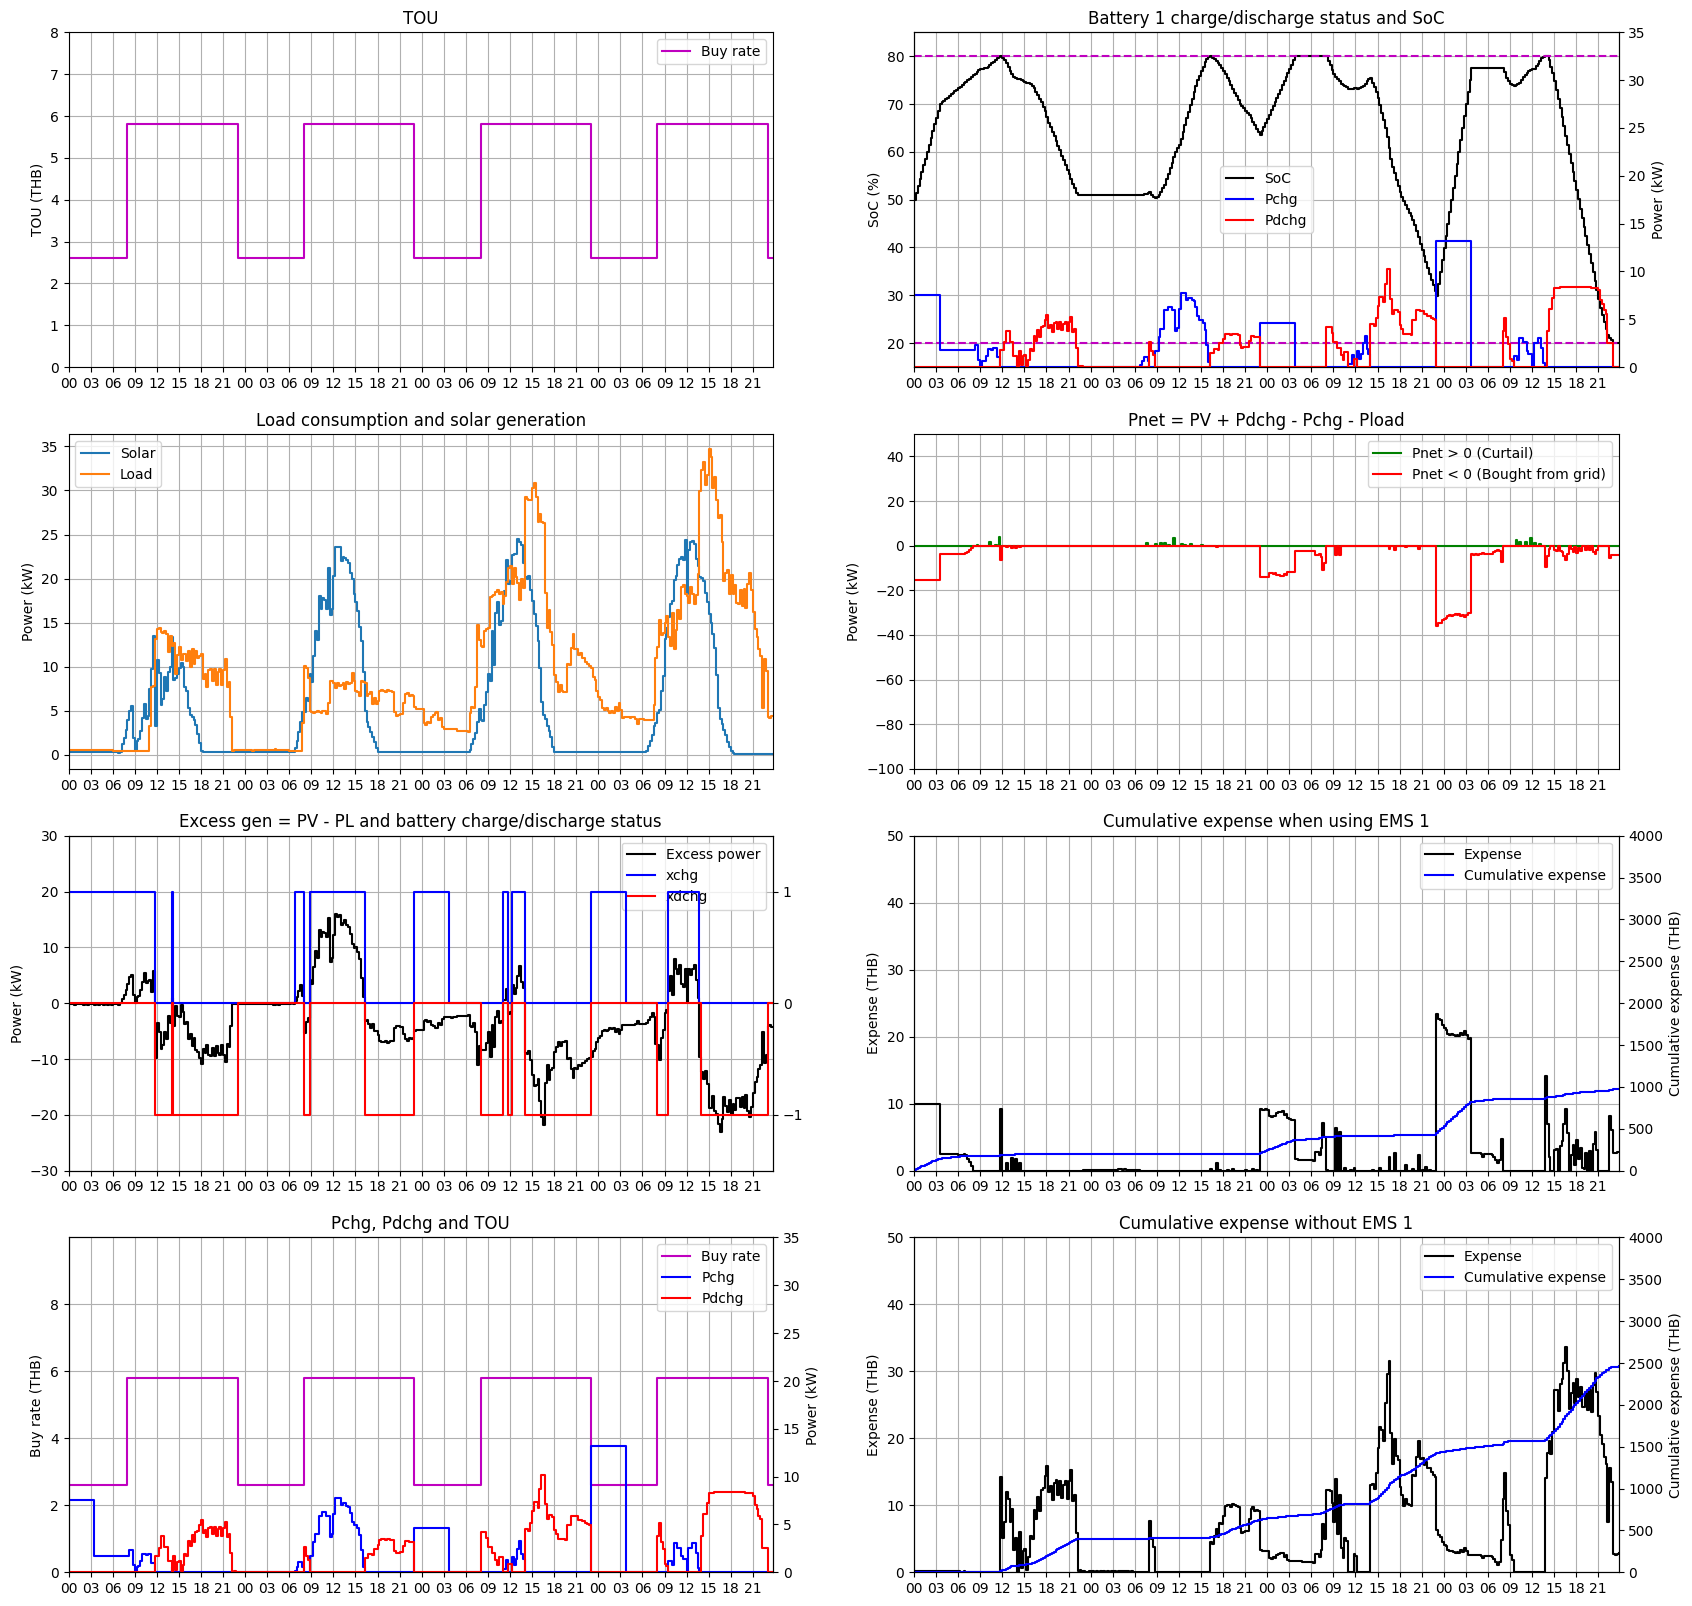

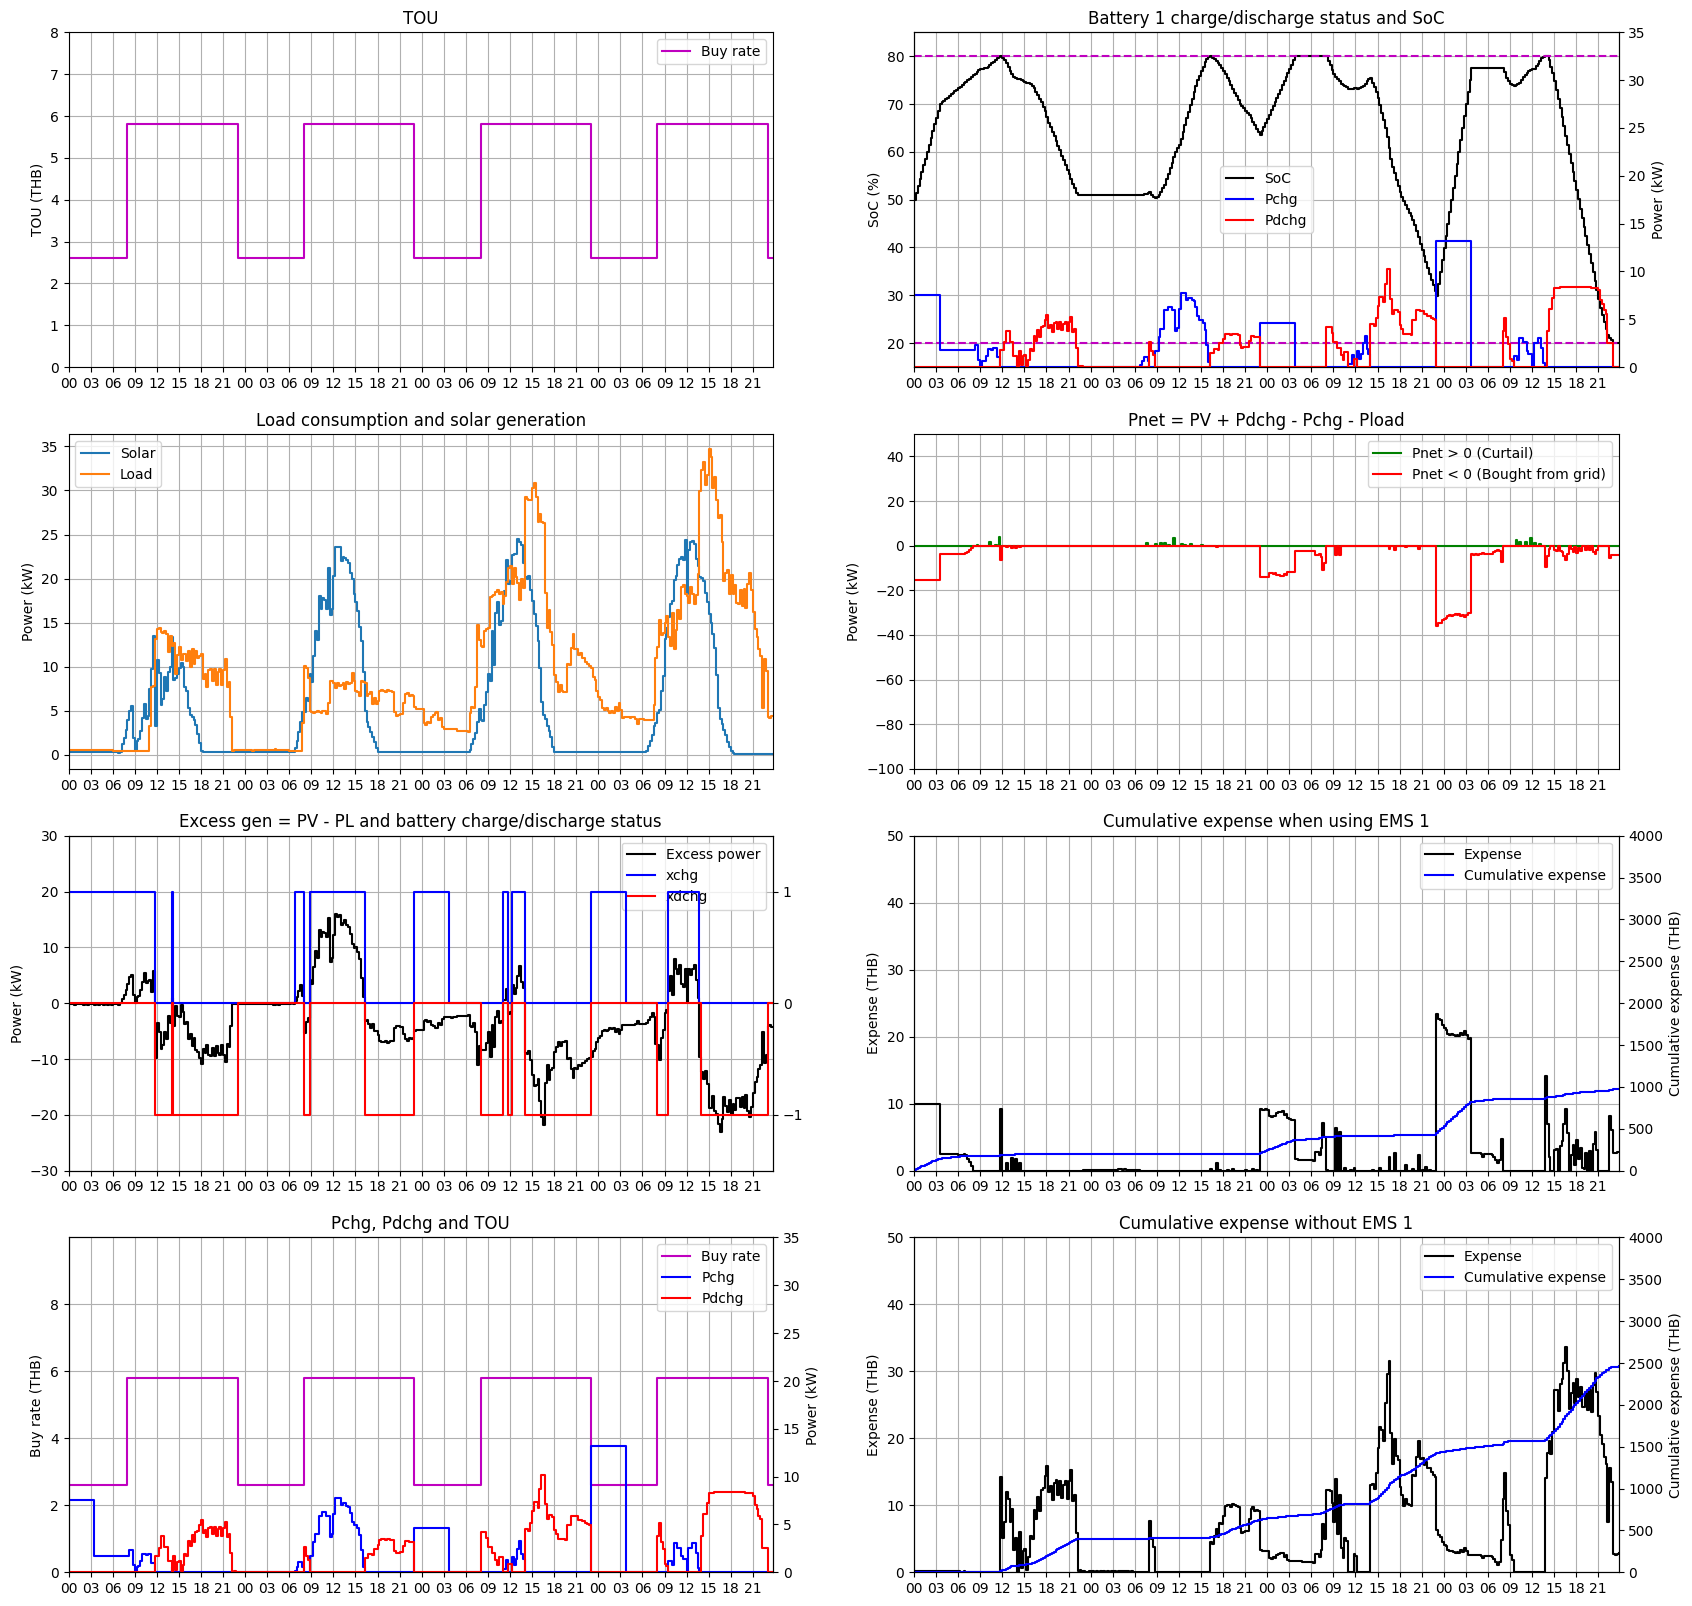

In [8]:
EMS_energycost_plot(PARAM,sol)

In [9]:
sum(sol['Pnet'])

-1352.249885712436

In [10]:
sum(sol['Buy_rate'])

1766.3999999999903